This notebook is for running the result_plotter2.py script
It also includes utility functions for visualizing the data logged during the simulations, and saving the figures and logged data as tex.tables.

In [21]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import pathlib
from glob import glob
from IPython.display import display
import os
import xlrd
from copy import deepcopy

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [27]:

# resultsPath = '../results/*/plots*'
resultsPath = 'note-outputs/2019*M2*'
allResults = glob(resultsPath)

# filenames = ['Results-TwoClusters-RepAtt-Q1-40-Noise0-100-xtlog',
#              'Results-TwoClusters-RW-var-turnP-xtlog','Results-2018-12-05-TwoClusters100m-RepAtt-vs-RW-100m']
display(allResults)


allResults = pd.Series(allResults)

# allResultsRWTurnP = allResults[allResults.str.contains('RW-turnP-xt')]
# display('allResultsRWTurnP',allResultsRWTurnP)

# allResultsRepAttQN = allResults[allResults.str.contains('Q1-40')]
# display('allResultsRepAttQN',allResultsRepAttQN)

# allResults100m = allResults[allResults.str.contains('100m')]
# display('allResults100m',allResults100m)

# display(allResults.iloc[0].split(os.sep))

[]

In [4]:

def visualize_robot_data(data,filename,sheet,xlabel,cs=5,legTitle='key',visible=True,xtick=[False,[]]):
#     print(filename+'-'+title)
#     print(data['latex'].to_string())
    colors = plt.cm.jet(np.linspace(0,1,cs))#did not find tab20 cm on my windows workstation
    f = plt.figure()
    yerr=[]
    for i in data['CI95'].columns:
        yerr.append([data['CI95'][i].values,data['CI95'][i].values])
    data['Mean'].plot(kind='bar',ax = f.gca(),color=colors,
                      rot=0,width=0.8,figsize=(10,5),yerr=yerr)
    plt.legend(loc='center left',bbox_to_anchor=(1,0.5),title=legTitle).set_visible(visible)
    ylabel = ''
    if sheet.startswith('t_') or sheet == 'litter_data':
        ylabel = 'Time in Seconds'
    else:
        ylabel = sheet.replace('_',' ')
        
        #if it contains dist, change it to distance
        ylabel = ylabel.replace('dist','Distance in Metres')
        
        #if it contains rot, change it to rotation
        ylabel = ylabel.replace('rot', 'Rotation')
        
        #if it contains num, change it to number
        ylabel = ylabel.replace('num', 'Number of')
        
        ylabel = ylabel.capitalize()
        
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if xtick[0]:#if xtick is supplied, use the value supplied
        plt.xticks(xtick[1])
#     plt.title(title)
    
#     plt.ylim([0, robot_data['turnP'].max() * 1.2])
    f.savefig(filename+sheet + '.pdf', bbox_inches='tight')#save before showing the title on notebook
    plt.title(sheet)
    plt.close()


### Plot Stacked Bar Chart of Robot States
A utility function for plotting stacked bar plots of different quantities, where the quantities to be stacked are the columns of a DataFrame. This function was originaly defined for comparing the times spent by the swarm in searching, homing, go4litter and obstacle avoidance states.

In [5]:
def plot_stacked(df,filename,sheet='stateTimeDataNormalized',swarm_size=36,stacked=True,cs=4,legTitle='key',visible=True):
    colors = plt.cm.jet(np.linspace(0,1,cs))#did not find tab20 cm
    df.columns = [ix.replace('_','-') for ix in df.columns]
    
    df = df.sort_index()/swarm_size
    df = (df.transpose() / df.sum(axis=1).values).transpose() * 100
    
    f = plt.figure()
    df.plot(kind='bar',ax=f.gca(),color=colors,stacked=stacked)
    plt.legend(loc='center left',bbox_to_anchor=(1,0.5),title=legTitle).set_visible(visible)
    plt.xlabel('Algorithm')
    plt.ylabel('Normalized Time')
    f.savefig(filename+sheet + '.pdf', bbox_inches='tight')#save before showing the title on notebook
    plt.title(sheet)
    plt.close()
    return df

### Plot the trend in Litter Data
This shows the trend in time taken to forage a particular percentage of litter.

In [6]:
def plotDataTrend(data,path,sheet,xlabel,cs=5,legTitle='key',visible=True,xtick=[False,[]]):
    for cl in data['Mean'].columns:
        if 'Noise' in cl:
            col = cl.split('-')
            N = int(re.findall('\d+',col[1])[0])
            Q = int(re.findall('\d+',col[2])[0])
            col = '{}-N{:03d}-Q{:02d}'.format(col[0],N,Q)
            data['Mean'].rename(columns={cl:col},inplace=True)
            data['CI95'].rename(columns={cl:col},inplace=True)

    colors = plt.cm.jet(np.linspace(0,1,len(data['Mean'].columns)))#did not find tab20 cm on my windows workstation
    f = plt.figure()
    yerr=[]
    for i in data['CI95'].columns:
        yerr.append([data['CI95'][i].values,data['CI95'][i].values])
    data['Mean'].plot(kind='bar',ax = f.gca(),color=colors,
                      rot=0,width=0.8,figsize=(10,5),yerr=yerr)
    plt.legend(loc='center left',bbox_to_anchor=(1,0.5),title=legTitle).set_visible(visible)
    ylabel = 'Time in Seconds'
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if xtick[0]:#if xtick is supplied, use the value supplied
        plt.xticks(xtick[1])
#     plt.title(title)
    
#     plt.ylim([0, robot_data['turnP'].max() * 1.2])
    f.savefig(path+sheet + '_trend' + '.pdf', bbox_inches='tight')#save before showing the title on notebook
    plt.title(sheet)
#     input('>')
#     plt.close()

## Using dist utils to copy processed results files

In [7]:
import distutils
import setuptools
import shutil
def copy_results(src,foldername,resultFile,dst):
#     shutil.copy2(src + resultFile, src + foldername + '/' + resultFile)
    !cp {src}{resultFile} {src}{foldername}/
    !cp -r {src}{foldername}/ {dst}/
#     !distutils.dir_util.copy_tree(src + foldername + '\\', dst + foldername, preserve_mode = 0)

## Logged Paremeters for RepAtt
In this experiment I present plots of the various parameters logged by RepAtt algorithm.

In [19]:
def generate_plots_n_data(path,filename,folderName,Algorithms, world,
                          columns,index,xlabel,legTitle,legendVisible,cs,xtick=[False,[]]):
    xcelFileName = [path,'/',filename]
    analysisFolder = path+'/'+'/'
    pathlib.Path(analysisFolder).mkdir(parents=False,exist_ok=True)

    sheetnames = pd.ExcelFile(''.join(xcelFileName)).sheet_names
#     display(sheetnames)
#     stateTimeData = {'t_obstacle_avoidance':'','t_searching':'','t_go4litter':'','t_homing':''}
    stateTimeData = {'Mean':pd.DataFrame(columns=['t_obstacle_avoidance','t_searching','t_go4litter','t_homing']),
                     'CI95':pd.DataFrame(columns=['t_obstacle_avoidance','t_searching','t_go4litter','t_homing']),
                     'latex':pd.DataFrame(columns=['t_obstacle_avoidance','t_searching','t_go4litter','t_homing'])}
    
    for sheet in sheetnames:
        resultMean = pd.read_excel(''.join(xcelFileName),sheet_name=sheet,usecols="A:L")#in newer versions change columns to usecols
        resultCI95 = pd.read_excel(''.join(xcelFileName),sheet_name=sheet,usecols="N:Y")
        
        if sheet == 'litter_data':
            plotDataTrend({'Mean': resultMean.transpose(),
                          'CI95': resultCI95.transpose()},
                          analysisFolder,sheet,'Percentage of Litter in Nest',cs=5,legTitle='key',visible=True,xtick=[False,[]])
        repAttqSizeNoise = {'Mean':pd.DataFrame(columns=columns,index=index),
                            'CI95':pd.DataFrame(columns=columns,index=index),
                           'latex':pd.DataFrame(columns=columns,index=index)}
        for a in resultMean.index:
            b = a.split('-')
            N = re.findall('\d+',b[1])
            N = int(N[0])
            
            Q = re.findall('\d+',b[2])
            Q = int(Q[0])
            repAttqSizeNoise['Mean'].loc[N,Q] = resultMean.loc[a,90]
            repAttqSizeNoise['CI95'].loc[N,Q] = resultCI95.loc[a,90]
            repAttqSizeNoise['latex'].loc[N,Q] = \
            '${:.2f} \pm {:.2f}$'.format(resultMean.loc[a,90],resultCI95.loc[a,90])
            if sheet in stateTimeData['Mean'].columns:
                stateTimeData['Mean'].loc['N{:03d}-Q{:02d}'.format(N,Q),sheet] = resultMean.loc[a,90]
                stateTimeData['CI95'].loc['N{:03d}-Q{:02d}'.format(N,Q),sheet] = resultCI95.loc[a,90]
                stateTimeData['latex'].loc['N{:03d}-Q{:02d}'.format(N,Q),sheet] = \
            '${:.2f} \pm {:.2f}$'.format(resultMean.loc[a,90],resultCI95.loc[a,90])
            if sheet == 'litter_data':
#                 if 'RW-0p0025' in i:
                if (N == 0 and Q == 1) or (N == 100 and Q == 40):
#                     display(world,i)
#                     display( resultLatex.loc[i])
#                     display(Algorithms['RW-0p0025'])
                    Algorithms.loc['N{:03d}-Q{:02d}'.format(N,Q),world] = repAttqSizeNoise['latex'].loc[N,Q]
                
#         repAttqSizeNoise['latex'].columns = \
#                 [ix.replace('_','-') for ix in repAttqSizeNoise['latex'].columns]
        repAttqSizeNoise['latex'].to_latex(analysisFolder+sheet+'.tex',
                                           encoding='utf-8', escape=False)
        
        # repAttqSizeNoise['Mean'].plot.bar()
        
#         if sheet in stateTimeData.keys():
#             #If sheet is in the stateTimeData, add dictionary as column
#             stateTimeData[sheet] = repAttqSizeNoise
        
        visualize_robot_data(repAttqSizeNoise,analysisFolder,
                             sheet,xlabel,cs=cs,legTitle=legTitle,visible=legendVisible,xtick=xtick)
    for k in stateTimeData.keys():
        stateTimeData[k].columns = \
                        [ix.replace('_','-') for ix in stateTimeData[k].columns]
    return stateTimeData,Algorithms
    #     print(filenames[0]+'-'+sheet)
    #     display(repAttqSizeNoise['Mean'])
# xlabel='Noise Level'

### RepAtt 50m by 50m
Effect of Noise and Queue Size on RepAtt algorithm

2018-11-30-HalfCluster-RepAtt-Noise0-100pct-Q1-40-xtlog
2018-11-30-Uniform-RepAtt-Noise0-100pct-Q1-40-xtlog
2018-12-01-FourClusters-RepAtt-Noise0-100pct-Q1-40-xtlog
2018-12-01-HalfCluster-RepAtt-Noise0-100pct-Q1-40-xtlog
2018-12-01-OneCluster-RepAtt-Noise0-100pct-Q1-40-xtlog
2018-12-01-TwoClusters-RepAtt-Noise0-100pct-Q1-40-xtlog


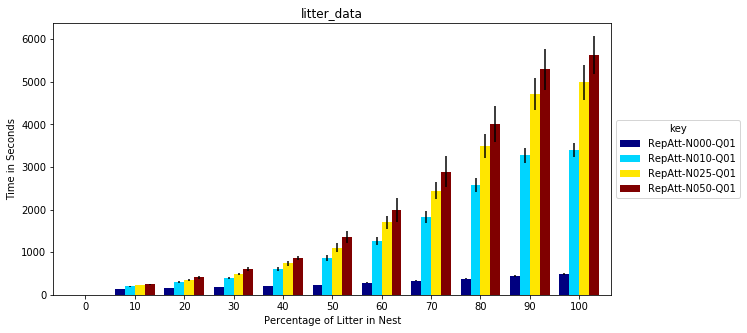

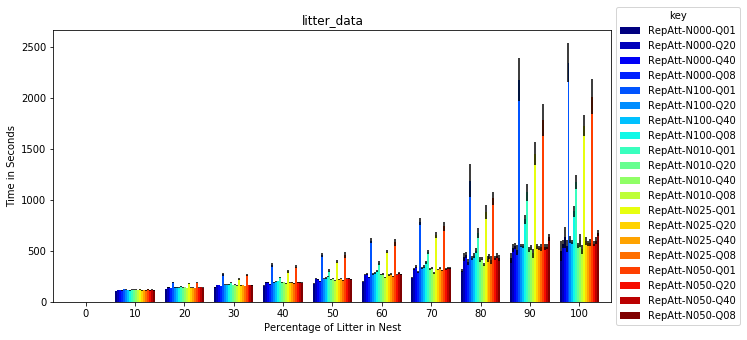

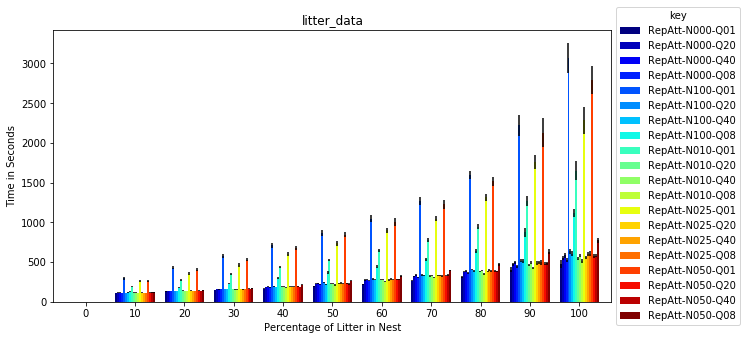

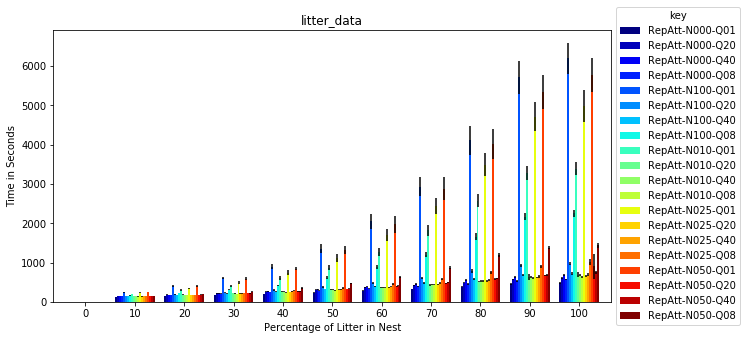

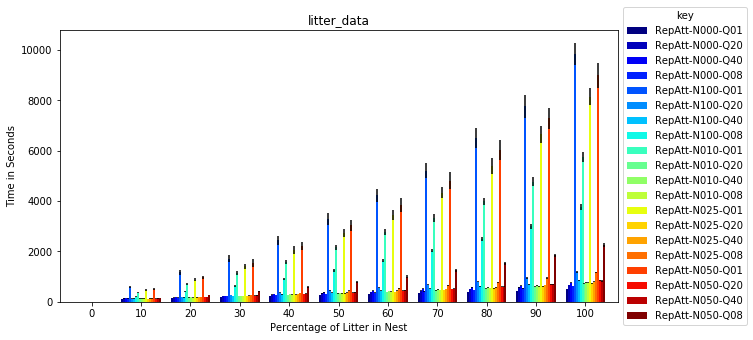

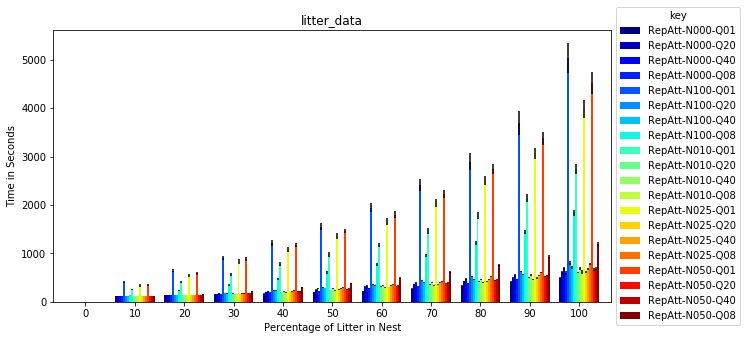

In [23]:
allResultsRepAttQN = allResults[allResults.str.contains('Q1-40-xt')]
# display('allResultsRepAttQN',allResultsRepAttQN)
filename = 'Results.xlsx'
columns = [1,8,20,40] # queues
index = [0,10,25,50,100] # noise levels
# columns = [1,20,40] # queues
# index = [0,100] # noise levels
AlgorithmsRepAttQN50 = pd.DataFrame()
for path in allResultsRepAttQN:
    
    folderName = path.split(os.sep)[1] #format is ../results/expFolder/plotsNData. I want expFolder
    print(folderName)
    world = folderName.split('-')[3]#Get the world name from the folderName (usually in yyyy-mm-dd-world-etc format)
#     display(folderName)
    stateTimeData,AlgorithmsRepAttQN50 = generate_plots_n_data(path,filename,folderName,AlgorithmsRepAttQN50,world,
                                                             columns,index,'Noise Level',
                                                             'Queue Size',True,4,xtick=[False,[]])
    stateTimeDataNormalized = plot_stacked(stateTimeData['Mean'],path + '/')

#     stateTimeData['latex'].columns = \
#                     [ix.replace('_','-') for ix in stateTimeData['latex'].columns]
    stateTimeData['latex'].to_latex(path + '/stateTimeData.tex',
                                           encoding='utf-8', escape=False)
    
#     stateTimeDataNormalized.columns = \
#                     [ix.replace('_','-') for ix in stateTimeDataNormalized.columns]
    stateTimeDataNormalized.to_latex(path  + '/stateTimeDataNormalized.tex',
                                           encoding='utf-8', escape=False)


In [179]:
AlgorithmsRepAttQN50

,Uniform,FourClusters,HalfCluster,OneCluster,TwoClusters
N000-Q01,$429.83 \pm 48.26$,$403.67 \pm 31.92$,$447.17 \pm 21.06$,$425.93 \pm 7.51$,$402.53 \pm 16.85$
N100-Q40,$548.83 \pm 17.20$,$512.67 \pm 25.36$,$674.47 \pm 27.09$,$701.73 \pm 18.53$,$565.73 \pm 18.27$


### RepAtt 100m by 100m
Effect of Noise and Queue Size on RepAtt algorithm

2018-12-10-FourClusters100m-RepAtt-Noise0-100pct-Q1-40-100m
2018-12-10-HalfCluster100m-RepAtt-Noise0-100pct-Q1-40-100m
2018-12-10-OneCluster100m-RepAtt-Noise0-100pct-Q1-40-100m
2018-12-10-TwoClusters100m-RepAtt-Noise0-100pct-Q1-40-100m
2018-12-10-Uniform100m-RepAtt-Noise0-100pct-Q1-40-100m


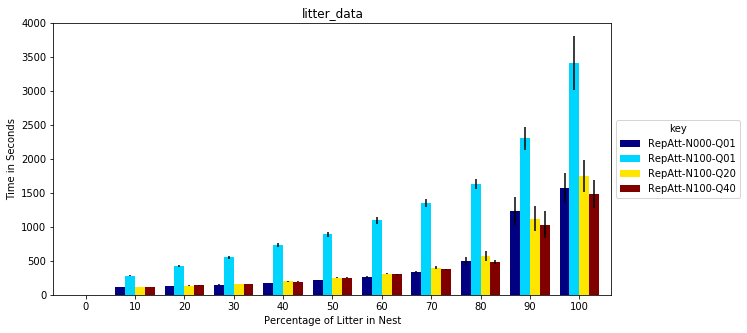

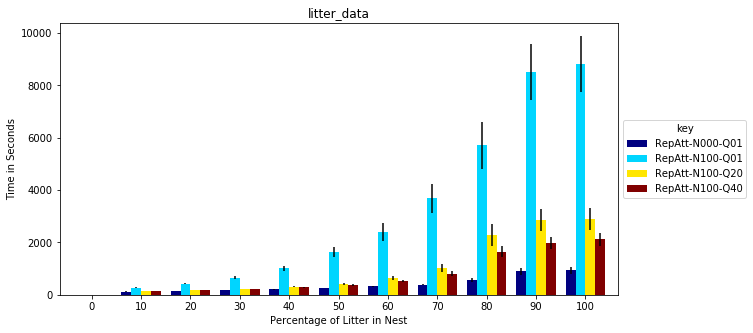

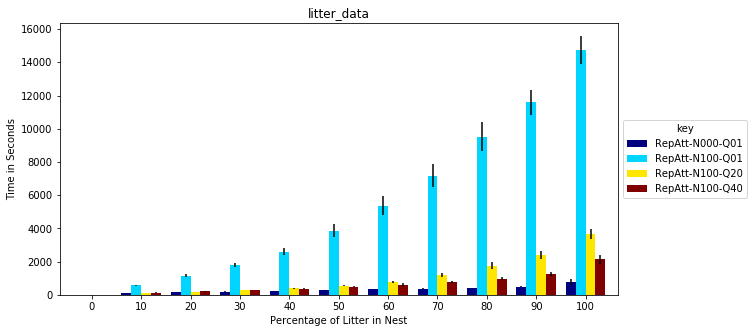

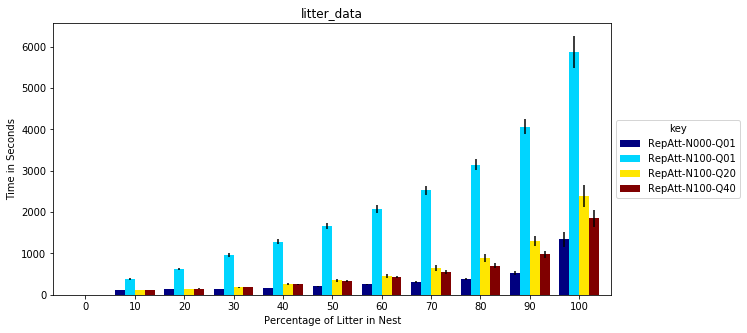

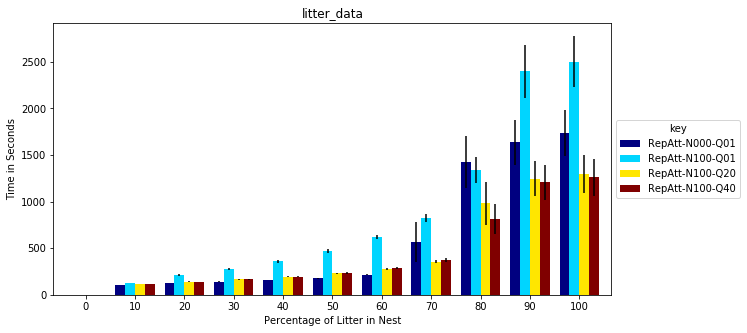

In [26]:
allResultsRepAttQN100 = allResults[allResults.str.contains('Q1-40-100m')]
# display('allResultsRepAttQN',allResultsRepAttQN)
filename = 'Results.xlsx'
# columns = [1,8,20,40] # queues
# index = [0,10,25,50,100] # noise levels
columns = [1,20,40] # queues
index = [0,100] # noise levels
AlgorithmsRepAttQN100 = pd.DataFrame()
for path in allResultsRepAttQN100:
    
    folderName = path.split(os.sep)[1] #format is ../results/expFolder/plotsNData. I want expFolder
    print(folderName)
    world = folderName.split('-')[3]#Get the world name from the folderName (usually in yyyy-mm-dd-world-etc format)
    
#     display(folderName)
    stateTimeData100,AlgorithmsRepAttQN100 = generate_plots_n_data(path,filename,folderName,AlgorithmsRepAttQN100,
                                                                   world,columns,index,'Noise Level',
                                                                   'Queue Size',True,4,xtick=[False,[]])
    stateTimeDataNormalized100 = plot_stacked(stateTimeData['Mean'],path +'/')

#     stateTimeData['latex'].columns = \
#                     [ix.replace('_','-') for ix in stateTimeData['latex'].columns]
    stateTimeData100['latex'].to_latex(path  + '/stateTimeData.tex',
                                           encoding='utf-8', escape=False)
    
#     stateTimeDataNormalized.columns = \
#                     [ix.replace('_','-') for ix in stateTimeDataNormalized.columns]
    stateTimeDataNormalized100.to_latex(path + '/stateTimeDataNormalized.tex',
                                           encoding='utf-8', escape=False)


In [62]:
AlgorithmsRepAttQN100

,FourClusters100m,HalfCluster100m,OneCluster100m,TwoClusters100m,Uniform100m
N000-Q01,$1227.83 \pm 209.67$,$892.83 \pm 118.03$,$494.21 \pm 12.93$,$525.47 \pm 39.09$,$1633.77 \pm 243.64$
N100-Q40,$1034.13 \pm 191.64$,$1969.83 \pm 219.81$,$1260.30 \pm 133.36$,$976.27 \pm 85.40$,$1205.87 \pm 191.68$


In [9]:
allResultsRepAttQN = allResults[allResults.str.contains('Q1-40-xt')]
filename = 'Results.xlsx'
for path in allResultsRepAttQN:
    folderName = path.split(os.sep)[2] #format is ../results/expFolder/plotsNData. I want expFolder
    copy_results(path + '/',folderName,filename,'./note-outputs/')
    

## Logged Parameters for Random Walk
In this section the turn probability of random walk was varied and data logged are shown below

In [27]:
def generate_plots_n_dataRW(path,filename,folderName,RW50mDF,world,xlabel,legTitle,legendVisible,cs,xtick=[False,[]]):
    xcelFileName = [path,'/',filename]
    analysisFolder = path+'/'
    pathlib.Path(analysisFolder).mkdir(parents=False,exist_ok=True)

    stateTimeDataRW = {'Mean':pd.DataFrame(columns=['t_obstacle_avoidance','t_searching','t_go4litter','t_homing']),
                     'CI95':pd.DataFrame(columns=['t_obstacle_avoidance','t_searching','t_go4litter','t_homing']),
                     'latex':pd.DataFrame(columns=['t_obstacle_avoidance','t_searching','t_go4litter','t_homing'])}

    sheetnames = pd.ExcelFile(''.join(xcelFileName)).sheet_names
    for sheet in sheetnames:
        resultMean = pd.read_excel(''.join(xcelFileName),sheet_name=sheet,usecols="A:L")

        resultCI95 = pd.read_excel(''.join(xcelFileName),sheet_name=sheet,usecols="N:Y")

        if sheet == 'litter_data':
            plotDataTrend({'Mean': resultMean.transpose(),
                          'CI95': resultCI95.transpose()},
                          analysisFolder,sheet,'Percentage of Litter in Nest',cs=5,legTitle='key',visible=True,xtick=[False,[]])
        indexes = [i[3:-1].replace('p','.') for i in resultMean.index]
        indexes.sort()
        repAttqSizeNoise = {'Mean':pd.DataFrame(columns=[sheet],index=indexes),
                            'CI95':pd.DataFrame(columns=[sheet],index=indexes),
                           'latex':pd.DataFrame(columns=[sheet],index=indexes)}
        for a in resultMean.index:
            ind = a[3:-1].replace('p','.')
            repAttqSizeNoise['Mean'].loc[ind,sheet] = resultMean.loc[a,90]
            repAttqSizeNoise['CI95'].loc[ind,sheet] = resultCI95.loc[a,90]
            repAttqSizeNoise['latex'].loc[ind,sheet] = \
            '${:.2f} \pm {:.2f}$'.format(resultMean.loc[a,90],resultCI95.loc[a,90])
            if sheet == 'litter_data':
                if '0p0025' in a:
                    RW50mDF.loc[a,world] = repAttqSizeNoise['latex'].loc[ind,sheet]

            if sheet in stateTimeDataRW['Mean'].columns:
                stateTimeDataRW['Mean'].loc[ind,sheet] = resultMean.loc[a,90]
                stateTimeDataRW['CI95'].loc[ind,sheet] = resultCI95.loc[a,90]
                stateTimeDataRW['latex'].loc[ind,sheet] = \
            '${:.2f} \pm {:.2f}$'.format(resultMean.loc[a,90],resultCI95.loc[a,90])

        repAttqSizeNoise['latex'].columns = [ix.replace('_','-') for ix in repAttqSizeNoise['latex'].columns]
        repAttqSizeNoise['latex'].to_latex(analysisFolder+sheet+'.tex',
                                               encoding='utf-8', escape=False)
        # repAttqSizeNoise['Mean'].plot.bar()
        visualize_robot_data(repAttqSizeNoise,analysisFolder,sheet,
                         xlabel,cs=cs,legTitle=legTitle,visible=legendVisible,xtick=xtick)
    for k in stateTimeDataRW.keys():
        stateTimeDataRW[k].columns = \
                        [ix.replace('_','-') for ix in stateTimeDataRW[k].columns]
    return stateTimeDataRW,RW50mDF

#Plot the time spent in each state as normalized stacked bar plots    
# stateTimeDataRWNormalized = plot_stacked(stateTimeDataRW['Mean'],'./note-outputs/' + filenames[1]+'/')
# stateTimeDataRWNormalized.columns = \
#     [ix.replace('_','-') for ix in stateTimeDataRWNormalized.columns]
    
# stateTimeDataRWNormalized.to_latex('./note-outputs/' + filenames[1] + '/stateTimeDataNormalized.tex',
#                                            encoding='utf-8', escape=False)
#     print(filenames[1]+'-'+sheet)
#     display(repAttqSizeNoise['Mean'])


2018-11-30-FourClusters-RW-turnP-xtlog
2018-11-30-HalfCluster-RW-turnP-xtlog
2018-11-30-OneCluster-RW-turnP-xtlog
2018-11-30-TwoClusters-RW-turnP-xtlog
2018-11-30-Uniform-RW-turnP-xtlog


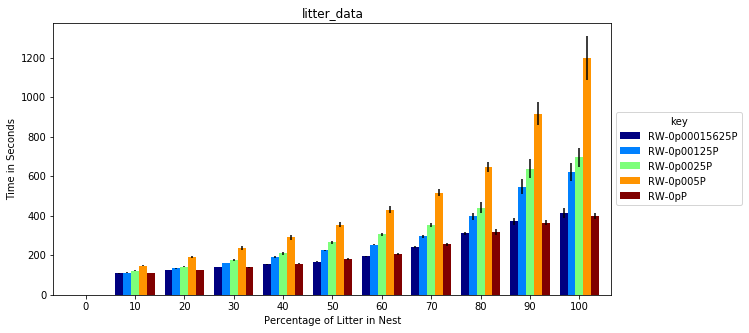

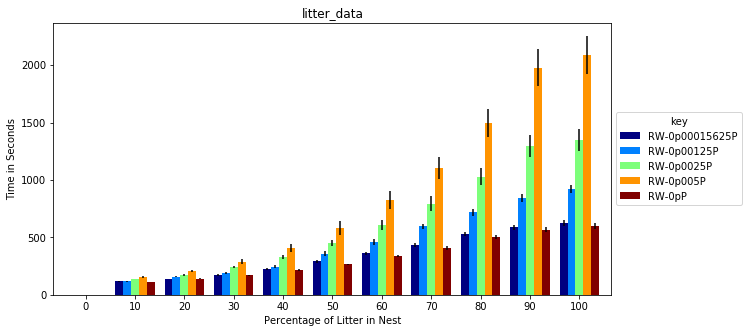

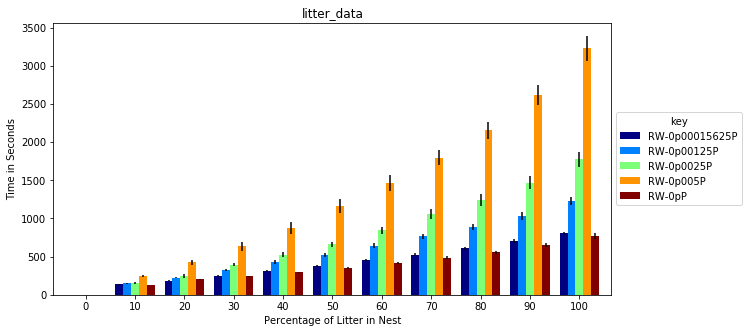

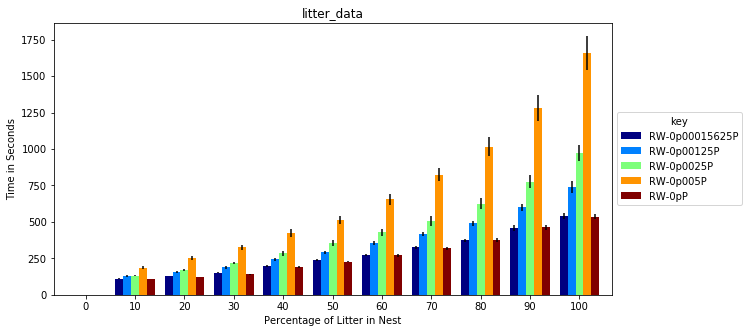

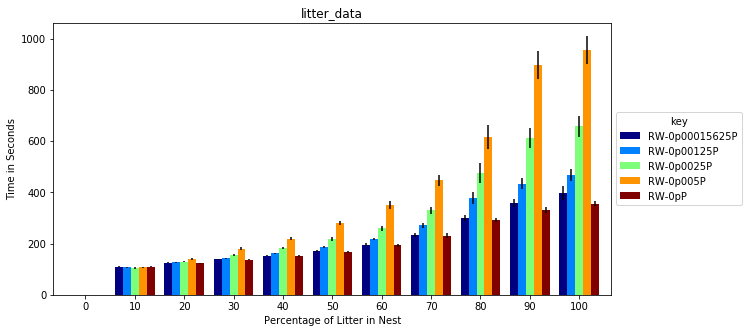

In [29]:
allResultsRWTurnP = allResults[allResults.str.contains('RW-turnP-xt')]
# display('allResultsRWTurnP',allResultsRWTurnP.iloc[0])
filename = 'Results.xlsx'
RW50mDF = pd.DataFrame()#columns=['OneCluster','TwoClusters','FourClusters','HalfCluster','Uniform'])
for path in allResultsRWTurnP:
    
    folderName = path.split(os.sep)[1] #format is ../results/expFolder/plotsNData. I want expFolder
    print(folderName)
    world = folderName.split('-')[3]#Get the world name from the folderName (usually in yyyy-mm-dd-world-etc format)
    
    stateTimeData,RW50mDF = generate_plots_n_dataRW(path,filename,folderName,RW50mDF,world,
                                                      'Turn Probability','Parameter',False,1,xtick=[False,[]])
    
    stateTimeData['latex'].to_latex(path + '/stateTimeData.tex',
                                           encoding='utf-8', escape=False)
#     display(stateTimeData['Mean'])
    stateTimeDataRWNormalized = plot_stacked(stateTimeData['Mean'],path +'/')

#     stateTimeDataRWNormalized.columns = \
#                     [ix.replace('_','-') for ix in stateTimeDataRWNormalized.columns]
    stateTimeDataRWNormalized.to_latex(path  + '/stateTimeDataNormalized.tex',
                                           encoding='utf-8', escape=False)


In [15]:
RW50mDF

,FourClusters,HalfCluster,OneCluster,TwoClusters,Uniform
RW-0p0025P,$638.80 \pm 48.98$,$1298.67 \pm 94.57$,$1470.07 \pm 80.46$,$775.63 \pm 45.77$,$612.43 \pm 40.47$


In [55]:
allResultsRWTurnP = allResults[allResults.str.contains('RW-turnP-xt')]
filename = 'Results.xlsx'
for path in allResultsRWTurnP:
    folderName = path.split(os.sep)[1] #format is ../results/expFolder/plotsNData. I want expFolder
    copy_results(path + '\\',folderName,filename,'./note-outputs/')
    

## RepAtt vs Random Walk in 100m world
In this set of results, I investigate the difference in performance when the world size is now 100m by 100m.

In [8]:
def generate_plots_n_dataRepAtt_RW(path,filename,folderName,Algorithms,world,
                                   xlabel,legTitle,legendVisible,cs,xtick=[False,[]]):
    xcelFileName = [path,'/',filename]
    analysisFolder = path+'/'
    pathlib.Path(analysisFolder).mkdir(parents=False,exist_ok=True)

    
    stateTimeDataRepAtt_vs_RW = {'Mean':pd.DataFrame(columns=['t_obstacle_avoidance','t_searching','t_go4litter','t_homing']),
                     'CI95':pd.DataFrame(columns=['t_obstacle_avoidance','t_searching','t_go4litter','t_homing']),
                     'latex':pd.DataFrame(columns=['t_obstacle_avoidance','t_searching','t_go4litter','t_homing'])}

    sheetnames = pd.ExcelFile(''.join(xcelFileName)).sheet_names
    for sheet in sheetnames:
        resultMean = pd.read_excel(''.join(xcelFileName),sheet_name=sheet,usecols="A:L")
        resultCI95 = pd.read_excel(''.join(xcelFileName),sheet_name=sheet,usecols="N:Y")
        resultLatex = pd.DataFrame(columns=['Time'])
        
        for cl in resultMean.index:
            if 'Noise' in cl:
                col = cl.split('-')
                N = int(re.findall('\d+',col[1])[0])
                Q = int(re.findall('\d+',col[2])[0])
                col = '{}-N{:03d}-Q{:02d}'.format(col[0],N,Q)
                resultMean.rename(index={cl:col},inplace=True)
                resultCI95.rename(index={cl:col},inplace=True)
#                 display(resultMean.columns)
                

        if sheet == 'litter_data':
            plotDataTrend({'Mean': resultMean.transpose(),
                          'CI95': resultCI95.transpose()},
                          analysisFolder,sheet,'Percentage of Litter in Nest',cs=5,legTitle='key',visible=True,xtick=[False,[]])
        aMean = pd.DataFrame(columns=resultMean.index)
        aMean.loc[0] = resultMean[90].values
        aCI95 = pd.DataFrame(columns=resultCI95.index)
        aCI95.loc[0] = resultCI95[90].values
        resultDict = {'Mean': aMean,
                      'CI95': aCI95,
                      'latex': resultLatex}
        for i in resultMean.index:
            resultLatex.loc[i] = '${:.2f} \pm {:.2f}$'.format(resultMean.loc[i,90],resultCI95.loc[i,90])
            if sheet in stateTimeDataRepAtt_vs_RW['Mean'].columns:
                    stateTimeDataRepAtt_vs_RW['Mean'].loc[i,sheet] = resultMean.loc[i,90]
                    stateTimeDataRepAtt_vs_RW['CI95'].loc[i,sheet] = resultCI95.loc[i,90]
                    stateTimeDataRepAtt_vs_RW['latex'].loc[i,sheet] = \
                    '${:.2f} \pm {:.2f}$'.format(resultMean.loc[i,90],resultCI95.loc[i,90])
            if sheet == 'litter_data':
#                 if 'RW-0p0025' in i:
                if  any(x in i for x in ['RW-0p0025','RepAtt-N000-Q01','RepAtt-N100-Q40']):
#                     display(world,i)
#                     display( resultLatex.loc[i])
#                     display(Algorithms['RW-0p0025'])
                    Algorithms.loc[i,world] = resultLatex.loc[i,'Time']

        resultLatex.columns = \
            [ix.replace('_','-') for ix in resultLatex.columns]
        resultLatex.to_latex(analysisFolder+sheet+'.tex',
                                               encoding='utf-8', escape=False)
        visualize_robot_data(resultDict,analysisFolder,
                             sheet,'',cs=cs,legTitle=legTitle,xtick=xtick)
    for k in stateTimeDataRepAtt_vs_RW.keys():
        stateTimeDataRepAtt_vs_RW[k].columns = \
            [ix.replace('_','-') for ix in stateTimeDataRepAtt_vs_RW[k].columns]
    return stateTimeDataRepAtt_vs_RW,Algorithms
# stateTimeDataRepAtt_vs_RWNormalized = plot_stacked(stateTimeDataRepAtt_vs_RW['Mean'],
#                                                    './note-outputs/' + filenames[2]+'/',cs=4)

# stateTimeDataRepAtt_vs_RWNormalized.columns = \
#         [ix.replace('_','-') for ix in stateTimeDataRepAtt_vs_RWNormalized.columns]
# stateTimeDataRepAtt_vs_RWNormalized.to_latex('./note-outputs/' + filenames[2] + '/stateTimeDataNormalized.tex',
#                                            encoding='utf-8', escape=False)

2019-02-05-OneCluster-SA-N0-M1-1000-D1-1000-unltd
2019-02-05-OneCluster100m-SA-N0-M1-1000-D1-1000-unltd
2019-02-05-OneClusterUnbounded-SA-N0-M1-1000-D1-1000-unltd
2019-02-05-Uniform-SA-N0-M1-1000-D1-1000-unltd
2019-02-05-Uniform100m-SA-N0-M1-1000-D1-1000-unltd
2019-02-05-UniformUnbounded-SA-N0-M1-1000-D1-1000-unltd


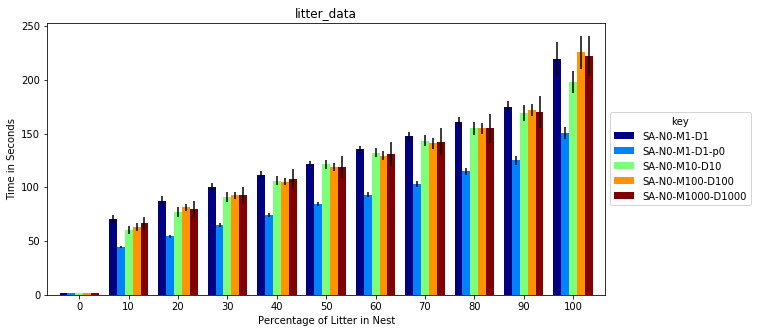

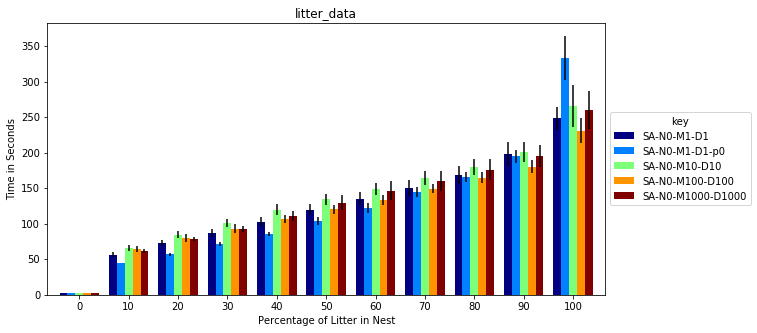

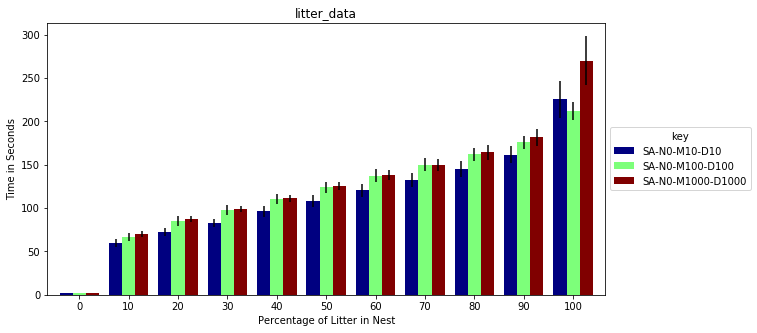

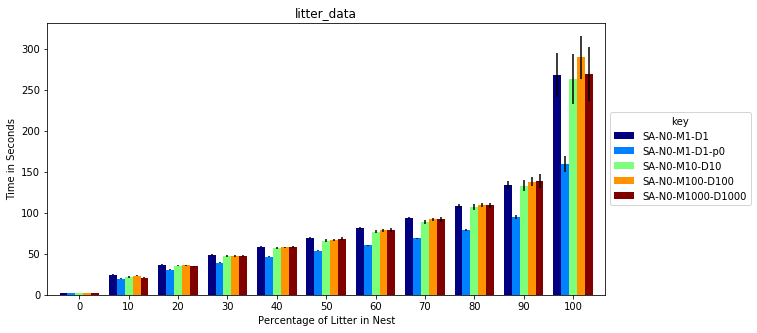

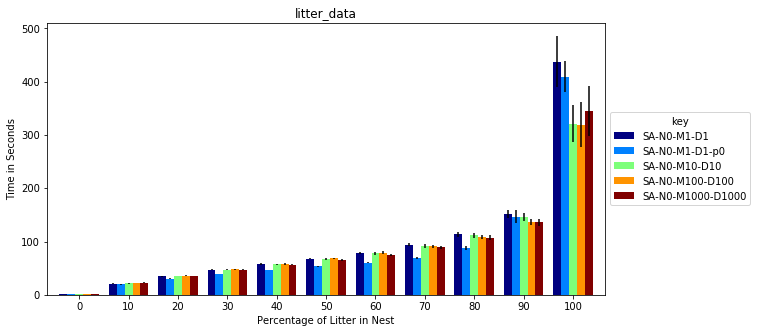

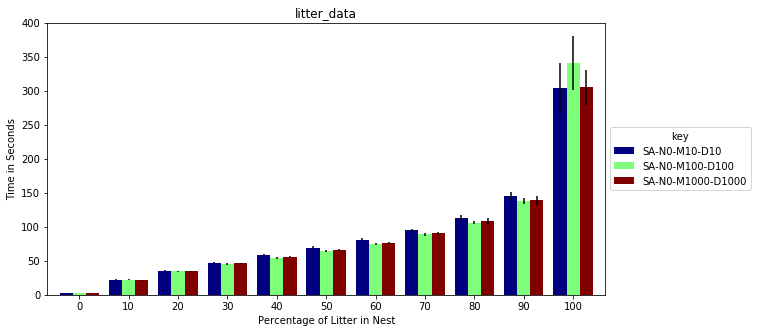

In [23]:
allResults100m = allResults#[allResults.str.contains('RepAtt-vs-RW-100m')]
# display('allResults100m',allResults100m.iloc[0])
filename = 'Results.xlsx'

RepAtt100mN0Q1 = pd.DataFrame()
RepAtt100mN100Q40 = pd.DataFrame()
RW100m = pd.DataFrame()
# Algorithms = {'RepAtt-N000-Q01': pd.DataFrame(index=Re),
#               'RepAtt-N100-Q40': pd.DataFrame(),
#               'RW-0p0025': pd.DataFrame()}
Algorithms100m = pd.DataFrame()
# display(Algorithms['RepAtt-N000-Q01'])
for path in allResults100m:
    
    folderName = path.split(os.sep)[1] #format is ../results/expFolder/plotsNData. I want expFolder
    print(folderName)
    world = folderName.split('-')[3]#Get the world name from the folderName (usually in yyyy-mm-dd-world-etc format)
    
    stateTimeData,Algorithms100m = generate_plots_n_dataRepAtt_RW(path,filename,folderName,Algorithms100m,world,
                                                              '','Algorithm',True,4,xtick=[True,[]])
    stateTimeDataRepAtt_vs_RWNormalized = plot_stacked(stateTimeData['Mean'],path  +'/')

    stateTimeData['latex'].to_latex(path  + '/stateTimeData.tex',
                                           encoding='utf-8', escape=False)
    
#     stateTimeDataRepAtt_vs_RWNormalized.columns = \
#                     [ix.replace('_','-') for ix in stateTimeDataRepAtt_vs_RWNormalized.columns]
    stateTimeDataRepAtt_vs_RWNormalized.to_latex(path + '/stateTimeDataNormalized.tex',
                                           encoding='utf-8', escape=False)


In [24]:
import os
import pathlib
for folder in allResults:
#     print(folder.split(os.sep)[-1])
#     break
    dest = 'note-outputs/20190206-results/' + folder.split(os.sep)[-1] + '-litter_data.pdf'

    
    !cp {folder + '/litter_data.pdf'} {dest}


In [57]:
allResults100m = allResults[allResults.str.contains('RepAtt-vs-RW-100m')]
filename = 'Results.xlsx'
for path in allResults100m:
    folderName = path.split(os.sep)[1] #format is ../results/expFolder/plotsNData. I want expFolder
    copy_results(path + '\\',folderName,filename,'./note-outputs/')
    

## Normalize and Plot Foraging Times

In [35]:
def renameColandIndex(Alg):
    Algorithms = deepcopy(Alg)
    
    cols = Algorithms.columns
    cols = [i.replace('100m','') for i in cols]
    Algorithms.columns = cols
    
    colOrder = ['OneCluster','TwoClusters','FourClusters','HalfCluster','Uniform']
    Algorithms = Algorithms[colOrder]#Reorder the columns
    
    Algorithms.rename(index = {'RW-0p0025P':'RW-0.0025'}, inplace = True)
    
    return Algorithms
    

In [36]:
def plotLatexAlgVSworld(Algorithms,title):
    analysisFolder = './note-outputs/summarized-plots/'
    pathlib.Path(analysisFolder).mkdir(parents=False,exist_ok=True)
    aMean,aCI95 = latex2MeanCI95(Algorithms,normalized=False)
    
    aMean,aCI95 = aMean.transpose(),aCI95.transpose()
#     aCI95 = aCI95.div(aMean.loc['RW-0p0025P',:]).transpose()
    
    colors = plt.cm.jet(np.linspace(0,1,len(aMean.columns)))#did not find tab20 cm on my windows workstation
    
    
    f = plt.figure()
    
    yerr=[]
    for i in aCI95.columns:
        yerr.append([aCI95[i].values,aCI95[i].values])
    
    aMean.plot(kind='bar',ax = f.gca(),color=colors,
                      rot=0,width=0.8,figsize=(10,5),yerr=yerr)
    plt.legend(loc='center left',bbox_to_anchor=(1,0.5),title='Distributions').set_visible(True)
    
    plt.ylabel('Time in Seconds')
    plt.xlabel('World Size')
        
#     plt.ylim([0, robot_data['turnP'].max() * 1.2])
    f.savefig(analysisFolder + '-'.join(title) + '.pdf', bbox_inches='tight')#save before showing the title on notebook
    Algorithms.to_latex(analysisFolder + '-'.join(title) + '.tex',
                                           encoding='utf-8', escape=False)
    plt.title(' '.join(title))
#     plt.close()


In [37]:
#Sort The columns
AlgorithmsRepAttQN50sorted = AlgorithmsRepAttQN50.sort_index(axis=1)
AlgorithmsRepAttQN100sorted = AlgorithmsRepAttQN100.sort_index(axis=1)
Algorithms100msorted = Algorithms100m.sort_index(axis=1)
RW50mDFsorted = RW50mDF.sort_index(axis=1)

In [38]:
#Append RW to algorithms that do not have it
AlgorithmsRepAttQN50sorted = AlgorithmsRepAttQN50sorted.append(RW50mDFsorted)
AlgorithmsRepAttQN100sorted = AlgorithmsRepAttQN100sorted.append(Algorithms100msorted.loc['RW-0p0025P',:])

In [39]:
#rename and reorder column and index
AlgorithmsRepAttQN50sorted = renameColandIndex(AlgorithmsRepAttQN50sorted)
AlgorithmsRepAttQN100sorted = renameColandIndex(AlgorithmsRepAttQN100sorted)
Algorithms100msorted = renameColandIndex(Algorithms100msorted)
RW50mDFsorted = renameColandIndex(RW50mDFsorted)

In [40]:
#Append RW to algorithms that do not have it
AlgorithmsRepAttQN50sorted
# Algorithms100msorted
# AlgorithmsRepAttQN100sorted

,OneCluster,TwoClusters,FourClusters,HalfCluster,Uniform
N000-Q01,$425.93 \pm 7.51$,$402.53 \pm 16.85$,$403.67 \pm 31.92$,$447.17 \pm 21.06$,$429.83 \pm 48.26$
N100-Q40,$701.73 \pm 18.53$,$565.73 \pm 18.27$,$512.67 \pm 25.36$,$674.47 \pm 27.09$,$548.83 \pm 17.20$
RW-0.0025,$1470.07 \pm 80.46$,$775.63 \pm 45.77$,$638.80 \pm 48.98$,$1298.67 \pm 94.57$,$612.43 \pm 40.47$


In [41]:
RWDF = pd.DataFrame({'50m':RW50mDFsorted.loc['RW-0.0025',:], '100m': Algorithms100msorted.loc['RW-0.0025',:]})
RWDF = RWDF[['50m','100m']]

RepAttN0Q1 = pd.DataFrame({'50m':AlgorithmsRepAttQN50sorted.loc['N000-Q01',:], 
                     '100m': AlgorithmsRepAttQN100sorted.loc['N000-Q01',:]})
RepAttN0Q1 = RepAttN0Q1[['50m','100m']]

RepAttN100Q40 = pd.DataFrame({'50m':AlgorithmsRepAttQN50sorted.loc['N100-Q40',:], 
                     '100m': AlgorithmsRepAttQN100sorted.loc['N100-Q40',:]})
RepAttN100Q40 = RepAttN100Q40[['50m','100m']]


,50m,100m
OneCluster,$425.93 \pm 7.51$,$494.21 \pm 12.93$
TwoClusters,$402.53 \pm 16.85$,$525.47 \pm 39.09$
FourClusters,$403.67 \pm 31.92$,$1227.83 \pm 209.67$
HalfCluster,$447.17 \pm 21.06$,$892.83 \pm 118.03$
Uniform,$429.83 \pm 48.26$,$1633.77 \pm 243.64$


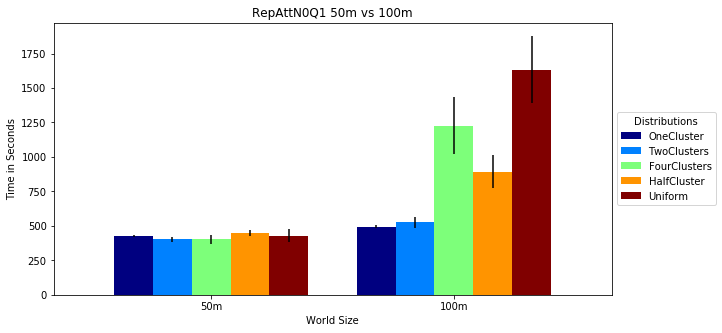

In [45]:
display(RepAttN0Q1)
plotLatexAlgVSworld(RepAttN0Q1,['RepAttN0Q1','50m','vs','100m'])

,50m,100m
OneCluster,$701.73 \pm 18.53$,$1260.30 \pm 133.36$
TwoClusters,$565.73 \pm 18.27$,$976.27 \pm 85.40$
FourClusters,$512.67 \pm 25.36$,$1034.13 \pm 191.64$
HalfCluster,$674.47 \pm 27.09$,$1969.83 \pm 219.81$
Uniform,$548.83 \pm 17.20$,$1205.87 \pm 191.68$


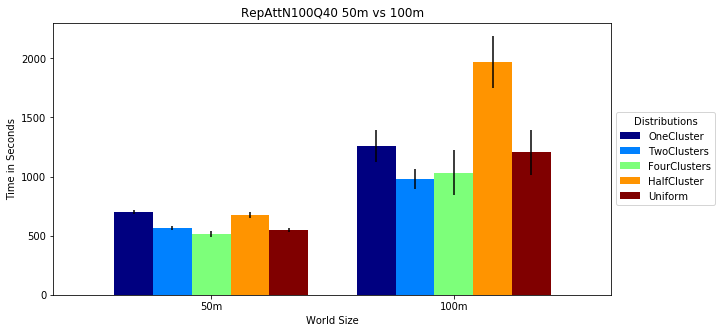

In [46]:
display(RepAttN100Q40)
plotLatexAlgVSworld(RepAttN100Q40,['RepAttN100Q40','50m','vs','100m'])

,50m,100m
OneCluster,$1470.07 \pm 80.46$,$13798.60 \pm 466.26$
TwoClusters,$775.63 \pm 45.77$,$4780.57 \pm 126.29$
FourClusters,$638.80 \pm 48.98$,$2064.80 \pm 58.19$
HalfCluster,$1298.67 \pm 94.57$,$6566.13 \pm 223.65$
Uniform,$612.43 \pm 40.47$,$1106.13 \pm 30.38$


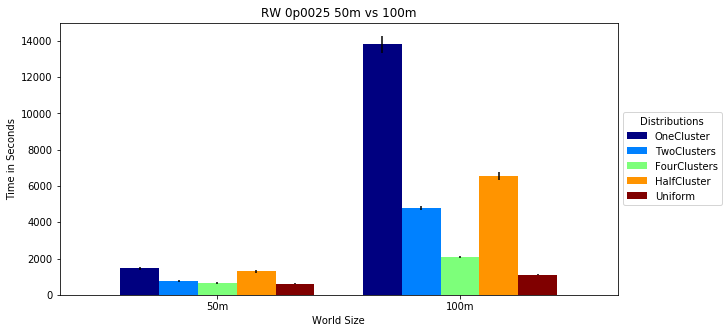

In [47]:
display(RWDF)
plotLatexAlgVSworld(RWDF,['RW','0p0025','50m','vs','100m'])

In [48]:
display('AlgorithmsRepAttQN50',AlgorithmsRepAttQN50)
display('AlgorithmsRepAttQN100',AlgorithmsRepAttQN100)
display('Algorithms100m',Algorithms100m)
display('RW50mDF',RW50mDF)

'AlgorithmsRepAttQN50'

,HalfCluster,Uniform,FourClusters,OneCluster,TwoClusters
N000-Q01,$447.17 \pm 21.06$,$429.83 \pm 48.26$,$403.67 \pm 31.92$,$425.93 \pm 7.51$,$402.53 \pm 16.85$
N100-Q40,$674.47 \pm 27.09$,$548.83 \pm 17.20$,$512.67 \pm 25.36$,$701.73 \pm 18.53$,$565.73 \pm 18.27$


'AlgorithmsRepAttQN100'

,FourClusters100m,HalfCluster100m,OneCluster100m,TwoClusters100m,Uniform100m
N000-Q01,$1227.83 \pm 209.67$,$892.83 \pm 118.03$,$494.21 \pm 12.93$,$525.47 \pm 39.09$,$1633.77 \pm 243.64$
N100-Q40,$1034.13 \pm 191.64$,$1969.83 \pm 219.81$,$1260.30 \pm 133.36$,$976.27 \pm 85.40$,$1205.87 \pm 191.68$


'Algorithms100m'

,TwoClusters100m,FourClusters100m,HalfCluster100m,OneCluster100m,Uniform100m
RW-0p0025P,$4780.57 \pm 126.29$,$2064.80 \pm 58.19$,$6566.13 \pm 223.65$,$13798.60 \pm 466.26$,$1106.13 \pm 30.38$
RepAtt-N000-Q01,$522.14 \pm 43.42$,$1330.93 \pm 271.64$,$1010.37 \pm 162.17$,$478.23 \pm 8.29$,$1493.27 \pm 199.10$
RepAtt-N100-Q40,$971.50 \pm 102.30$,$963.47 \pm 134.85$,$1574.93 \pm 140.68$,$1211.03 \pm 86.42$,$1121.33 \pm 155.29$


'RW50mDF'

,FourClusters,HalfCluster,OneCluster,TwoClusters,Uniform
RW-0p0025P,$638.80 \pm 48.98$,$1298.67 \pm 94.57$,$1470.07 \pm 80.46$,$775.63 \pm 45.77$,$612.43 \pm 40.47$


In [43]:
def latex2MeanCI95(Alg,normalized=True):
    Algorithms = deepcopy(Alg)
    
    a = Algorithms.applymap(lambda x: [float(i) for i in re.findall(r'\d+\.\d+',x)])
    aMean = a.applymap(lambda x: x[0])
    aCI95 = a.applymap(lambda x: x[1])
    if normalized:
        return aMean.div(aMean.loc['RW-0.0025',:]),aCI95.div(aMean.loc['RW-0.0025',:])
    else:
        return aMean,aCI95

In [167]:
def plotNormalizedLatex(Alg,title,legendElems):
    Algorithms = deepcopy(Alg)
    analysisFolder = './note-outputs/summarized-plots/'
    pathlib.Path(analysisFolder).mkdir(parents=False,exist_ok=True)
    
    RW = Algorithms.loc['RW-0.0025',:] #EXTRACT random walk row
    
    Algorithms = Algorithms.drop(['RW-0.0025'])
    Algorithms = Algorithms.append(RW)
    
    aMean,aCI95 = latex2MeanCI95(Algorithms,normalized=True)
    aMean,aCI95 = aMean.transpose(),aCI95.transpose()
#     aCI95 = aCI95.div(aMean.loc['RW-0p0025P',:]).transpose()
    
    colors = plt.cm.jet(np.linspace(0,1,len(aMean.columns)))#did not find tab20 cm on my windows workstation
    
    
    f = plt.figure()
    
    yerr=[]
    for i in aCI95.columns:
        yerr.append([aCI95[i].values,aCI95[i].values])
    
    aMean.plot(kind='bar',ax = f.gca(),color=colors,
                      rot=60,width=0.8,figsize=(7,5),yerr=yerr)
    
    legend = plt.legend(legendElems,loc='center left',bbox_to_anchor=(1,0.5),title='Algorithms',fontsize=18).set_visible(False)
# #     legend.()
#     plt.setp(legend.get_title(),fontsize=18)
    plt.ylabel('Normalized Foraging Time',fontsize=18)
#     plt.xlabel('Litter Distributions',fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
#     plt.ylim([0, robot_data['turnP'].max() * 1.2])
    f.savefig(analysisFolder + '-'.join(title) + '.pdf', bbox_inches='tight')#save before showing the title on notebook
    Algorithms.transpose().to_latex(analysisFolder + '-'.join(title) + '.tex',
                                           encoding='utf-8', escape=False)
    plt.title(' '.join(title))
#     plt.close()


In [169]:
AlgorithmsRepAttQN50sorted

,OneCluster,TwoClusters,FourClusters,HalfCluster,Uniform
N000-Q01,$425.93 \pm 7.51$,$402.53 \pm 16.85$,$403.67 \pm 31.92$,$447.17 \pm 21.06$,$429.83 \pm 48.26$
N100-Q40,$701.73 \pm 18.53$,$565.73 \pm 18.27$,$512.67 \pm 25.36$,$674.47 \pm 27.09$,$548.83 \pm 17.20$
RW-0.0025,$1470.07 \pm 80.46$,$775.63 \pm 45.77$,$638.80 \pm 48.98$,$1298.67 \pm 94.57$,$612.43 \pm 40.47$


In [173]:
(1298.67-674.47)/1298.67

0.4806455835585638

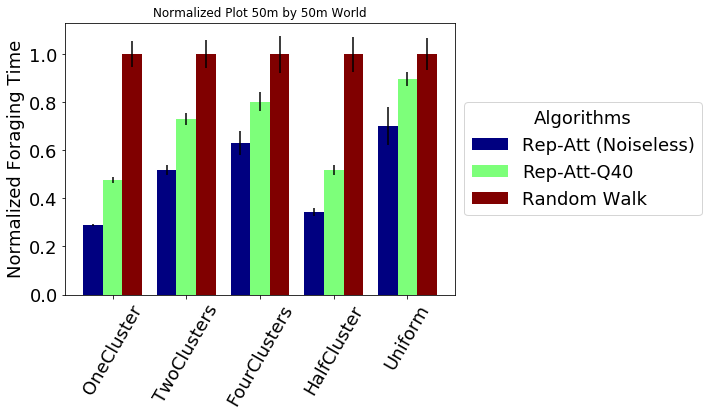

In [85]:
legendElems = ('Rep-Att (Noiseless)', 'Rep-Att-Q40', 'Random Walk')
plotNormalizedLatex(deepcopy(AlgorithmsRepAttQN50sorted),['Normalized', 'Plot', '50m', 'by', '50m', 'World'],legendElems)

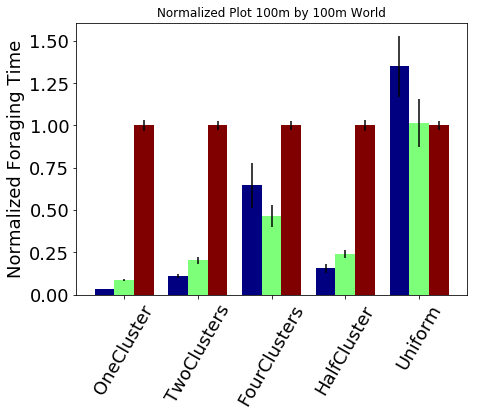

In [168]:
plotNormalizedLatex(deepcopy(Algorithms100msorted),['Normalized', 'Plot', '100m', 'by', '100m', 'World'],legendElems)

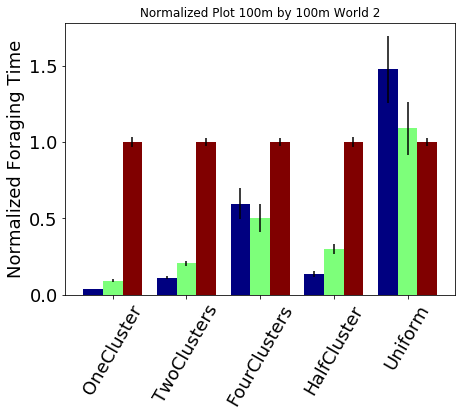

In [160]:
plotNormalizedLatex(deepcopy(AlgorithmsRepAttQN100sorted),['Normalized', 'Plot', '100m', 'by', '100m', 'World','2'],legendElems)

## RSS 2019 Plot Updates

,0,10,25,50,100
1,406.600006,2227.133301,3054.233398,3430.966553,3650.800049
8,480.833344,467.799988,605.799988,922.900024,1422.533325
20,523.533325,485.433319,497.233337,531.633362,614.833313
40,565.400024,552.066650,548.000000,537.266663,548.000000
80,604.833313,629.500000,602.366638,589.700012,598.533325


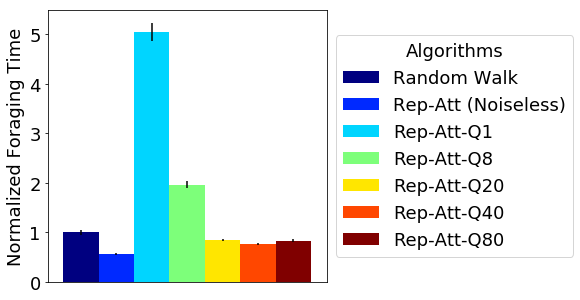

In [151]:
#investigate random walk vs repAtt qSize
RWMean = 723.37
RWCI = 33.61
xcelFile= 'assets/RSS19.xlsx'
sheet='2Clstr-RepAt-Nois-v-q-Gud'
resultMean = pd.read_excel(xcelFile,sheet_name=sheet,usecols="A:F")
resultCI95 = pd.read_excel(xcelFile,sheet_name=sheet,usecols="I:M")
display(resultMean)

# resultMean.plot(kind='bar')
names = ['Random Walk', 'Rep-Att (Noiseless)', 'Rep-Att-Q1', 'Rep-Att-Q8'
        , 'Rep-Att-Q20', 'Rep-Att-Q40', 'Rep-Att-Q80']
df = pd.DataFrame(columns=names)
df.loc[0,'Rep-Att-Q1':'Rep-Att-Q80'] = list(resultMean.loc[:,100].values)
df.loc[0,'Random Walk'] = RWMean
df.loc[0,'Rep-Att (Noiseless)'] = resultMean.loc[1,0]
df = df/RWMean # normalize values

dfCI = pd.DataFrame(columns=names)
dfCI.loc[0,'Rep-Att-Q1':'Rep-Att-Q80'] = list(resultCI95.loc[:,100].values)
dfCI.loc[0,'Random Walk'] = RWCI
dfCI.loc[0,'Rep-Att (Noiseless)'] = resultCI95.loc[1,0]
dfCI = dfCI/RWMean

# df.plot(kind='bar')

colors = plt.cm.jet(np.linspace(0,1,len(df.columns)))#did not find tab20 cm on my windows workstation
    
    
f = plt.figure()

yerr=[]
for i in dfCI.columns:
    yerr.append([dfCI[i].values,dfCI[i].values])

df.plot(kind='bar',ax = f.gca(),color=colors,
                  rot=60,width=4,figsize=(5,5),yerr=yerr)

legend = plt.legend(loc='center left',bbox_to_anchor=(1,0.5),title='Algorithms',fontsize=18)#.set_visible(True)
#     legend.()
plt.setp(legend.get_title(),fontsize=18)
plt.ylabel('Normalized Foraging Time',fontsize=18)
#     plt.xlabel('Litter Distributions',fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xticks([])
#     plt.ylim([0, robot_data['turnP'].max() * 1.2])
f.savefig('note-outputs/summarized-plots/2Clstr-RepAt-Nois-v-q-Gud' + '.pdf', bbox_inches='tight')#save before showing the title on notebook
# plt.title(' '.join(title))
# df['Rep-Att-Q1'] = resultMean
# resultMean[100].T.plot(kind='bar')

In [155]:
def plotNormalizedLinearComm(aMean,aCI95,title):
    
    analysisFolder = './note-outputs/summarized-plots/'
    pathlib.Path(analysisFolder).mkdir(parents=False,exist_ok=True)
    
     
#     aMean,aCI95 = latex2MeanCI95(Algorithms,normalized=True)
#     aMean,aCI95 = aMean.transpose(),aCI95.transpose()
#     aCI95 = aCI95.div(aMean.loc['RW-0p0025P',:]).transpose()
    
    colors = plt.cm.jet(np.linspace(0,1,len(aMean.columns)))#did not find tab20 cm on my windows workstation
    
    
    f = plt.figure()
    
    yerr=[]
    for i in aCI95.columns:
        yerr.append([aCI95[i].values,aCI95[i].values])
    
    aMean.plot(kind='bar',ax = f.gca(),color=colors,
                      rot=60,width=0.9,figsize=(10,5),yerr=yerr)
    
    legend = plt.legend(loc='center left',bbox_to_anchor=(1,0.5),title='Algorithms',fontsize=18)#.set_visible(True)
#     legend.()
    plt.setp(legend.get_title(),fontsize=18)
    plt.ylabel('Normalized Foraging Time',fontsize=18)
#     plt.xlabel('Litter Distributions',fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
#     plt.ylim([0, robot_data['turnP'].max() * 1.2])
    f.savefig(analysisFolder + title + '.pdf', bbox_inches='tight')#save before showing the title on notebook
    
    plt.title(' '.join(title))
#     plt.close()


,Random Walk,Repeller,Selective Repulsion,Selective Attraction,Rep-Att,Global Detector,Idealized Foraging
OneCluster,1.0,1.159187,0.671539,0.507885,0.511992,0.247429,0.090372
TwoCluster,1.0,0.971614,0.668932,0.675430,0.557555,0.473434,0.172174
FourCluster,1.0,0.740190,0.623496,0.923097,0.614593,0.521038,0.206320
HalfCluster,1.0,0.947034,0.598208,0.551598,0.499148,0.297472,0.100849
Uniform,1.0,0.877285,0.762777,0.995076,0.743169,0.512395,0.205480


,Random Walk,Repeller,Selective Repulsion,Selective Attraction,Rep-Att,Global Detector,Idealized Foraging
0,0.056110,0.024332,0.017619,0.030705,0.012415,0.006428,3.228014e-17
1,0.046465,0.031780,0.013476,0.036691,0.015848,0.010313,1.998128e-17
2,0.075695,0.041687,0.024548,0.056355,0.044065,0.008548,1.366645e-16
3,0.057927,0.039877,0.025596,0.044933,0.024252,0.007426,3.438150e-17
4,0.066618,0.124510,0.051152,0.066682,0.046317,0.015051,9.987937e-17


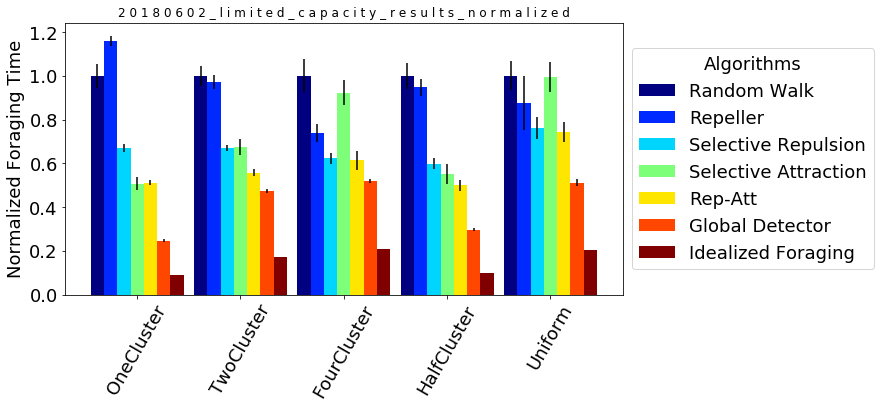

In [154]:
xcelFile= 'assets/RSS19.xlsx'
sheet='linear-rep-att-vs-others'
forageMean = pd.read_excel(xcelFile,sheet_name=sheet,usecols="A:H")
forageCI95 = pd.read_excel(xcelFile,sheet_name=sheet,usecols="J:P")


#normalize
forageMean,forageCI95 = forageMean.div(forageMean['Random Walk'],axis=0),forageCI95.div(forageMean['Random Walk'].values,axis=0)

display(forageMean)
display(forageCI95)
plotNormalizedLinearComm(forageMean,forageCI95,'20180602_limited_capacity_results_normalized')